<a href="https://colab.research.google.com/github/Heba-Atef99/Head_Pose_Estimation/blob/main/Head_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proplem Definition
Our problem is estimating the head pose using the three angles: (pitch, yaw, roll). As our input is an image of the face and the output is an image with three axes defining its position.

<center>
<img src="https://d226lax1qjow5r.cloudfront.net/blog/blogposts/attention-detection-with-vonage-video-api/46a877a98c1af6eae4a547a5248a315f.png" align="center"/>

<img src="https://miro.medium.com/max/691/1*U4ZQ8UjzouVMRo2Fgsz7UA.png" width='50%' align="center"/>
</center>


# Dataset
We will use AFLW2000 dataset which is a dataset of 2000 images that have been annotated with image-level 68-point 3D facial landmarks.

You can refer to the dataset [here](http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/main.htm)

<center>
<img src="https://production-media.paperswithcode.com/datasets/AFLW2000-3D-0000000545-76d6b875_KNCUxRx.jpg" align="center" width='40%'/>
</center>

# 1. Import Libraries

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 62.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
from math import cos, sin
import cv2
import mediapipe as mp
from scipy.io import loadmat
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# 2. Loading & Preparing Images

Mount the cotents of drive into the files of colab to access the AFLW2000 zip file

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copy the zip file fo from drive to the content folder on google colab

In [4]:
!cp /content/drive/MyDrive/Head_Pose_Estimation/AFLW2000-3D.zip /content

unzip the file

In [ ]:
dataset_path = '/content/AFLW2000'
if not os.path.exists(dataset_path):
  %cd /content
  !unzip AFLW2000-3D.zip;

collect the images' names and save it into a dataframe

In [6]:
dir_list = os.listdir(dataset_path)

In [7]:
images_list = list(filter(lambda file: file.endswith('.jpg'), dir_list))
images_names = list(map(lambda file: dataset_path + '/' + file.replace('.jpg', '') , images_list))

In [8]:
images_names[:5]

['/content/AFLW2000/image00499',
 '/content/AFLW2000/image01486',
 '/content/AFLW2000/image03799',
 '/content/AFLW2000/image01109',
 '/content/AFLW2000/image01688']

In [9]:
images_names = sorted(images_names)

save the images names in a dataframe

In [10]:
df = pd.DataFrame(images_names, columns=['image'])
df.head()

,image
0,/content/AFLW2000/image00002
1,/content/AFLW2000/image00004
2,/content/AFLW2000/image00006
3,/content/AFLW2000/image00008
4,/content/AFLW2000/image00010


explore one of the images

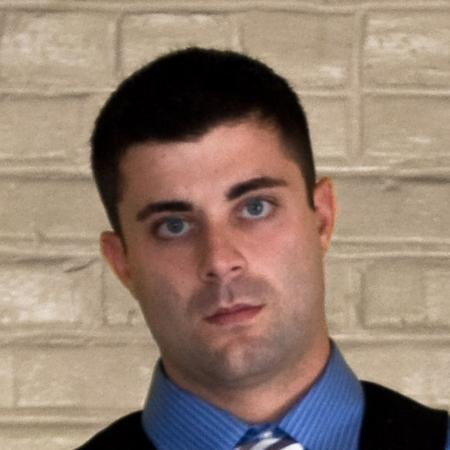

In [11]:
img = cv2.imread(df.iloc[5]['image']+'.jpg')
cv2_imshow(img)

explore the .mat file for that image

In [13]:
annots = loadmat(df.iloc[5]['image']+'.mat')
annots

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 29 22:50:26 2016',
 '__version__': '1.0',
 '__globals__': [],
 'pt2d': array([[136.67839196, 164.5678392 , 189.44221106, 229.3919598 ,
         260.29648241, 281.40201005, 158.53768844, 176.6281407 ,
         197.55994818, 242.13048764, 257.70853045, 277.18110695,
         135.24777697, 203.61807082, 217.89799707, 249.05408267,
         322.18429059, 210.54773869, 235.42211055, 257.28140704,
         244.72681277],
        [216.57788945, 207.53266332, 207.53266332, 191.70351759,
         182.65829146, 182.65829146, 231.65326633, 228.63819095,
         230.03871776, 217.05700009, 208.40250631, 209.26797869,
         293.64905153, 281.53280624, 263.79112849, 268.55108857,
         252.97304577, 318.33668342, 312.30653266, 308.53768844,
         377.59738819]]),
 'Illum_Para': array([[ 0.92531824,  0.85142124,  0.84738654,  0.55454063,  0.63420337,
          0.66929287,  0.07650548,  1.24921274,  0.02066589, 20. 

We are only interested in the pose parameters to get the pitch, yaw, and roll

In [ ]:
annots['Pose_Para'][0][0:3]

array([-0.02681173,  0.01196537, -0.22066212], dtype=float32)

# 3. Extract 2D Face Points & Save Ground Truth

We will use MediaPipe Face Mesh solution to extract the 2D semantic contours of the face as shown in the bellow figure.

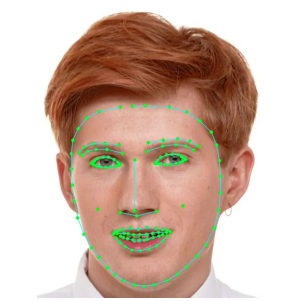

MediaPipe Face Mesh is a solution that estimates 478 3D face landmarks in real-time even on mobile devices. It employs machine learning (ML) to infer the 3D facial surface

You can learn more about mediapipe from [here](https://google.github.io/mediapipe/solutions/face_mesh.html)

Add another column (landmark) to the dataframe which will hold the 478 (x & y) face points of each image

Also add the pitch, yaw and roll columns

In [28]:
l_count = 478
landmarks = ['l' + str(i) for i in range(l_count*2)]
landmarks[:5]

['l0', 'l1', 'l2', 'l3', 'l4']

In [ ]:
df[landmarks] = 0
df['pitch'] = 0.0
df['yaw'] = 0.0
df['roll'] = 0.0

In [30]:
df.head()

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll
0,/content/AFLW2000/image00002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1,/content/AFLW2000/image00004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
2,/content/AFLW2000/image00006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
3,/content/AFLW2000/image00008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
4,/content/AFLW2000/image00010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


use face_mesh to extract the face points form each image

In [31]:
def get_2d_features(file):
  mp_face_mesh = mp.solutions.face_mesh
  with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.3) as face_mesh:
    image = cv2.imread(file)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
      face_landmarks = list(results.multi_face_landmarks[0].landmark)
      face_landmarks_2d = list(map(lambda landmark: [int(landmark.x * image.shape[0]), int(landmark.y * image.shape[1])], face_landmarks))
      return np.array(face_landmarks_2d, dtype=int).flatten()
    
    return None

In [32]:
def get_pitch_yaw_roll(file):
  annots = loadmat(file)
  return annots['Pose_Para'][0][0], annots['Pose_Para'][0][1], annots['Pose_Para'][0][2]

for each image extract its 2D features, read its labels and save them in the dataframe

In [33]:
for i in range(df.shape[0]):
  image_name = df['image'].iloc[i]
  image_file = image_name + '.jpg'
  mat_file = image_name + '.mat'
  # extract & save 2D features
  df.iloc[i, 1:-3] = get_2d_features(image_file)

  # read & save the three angels
  pose_parameters = get_pitch_yaw_roll(mat_file)
  # Pitch
  df.iloc[i, -3] = pose_parameters[0]
  # Yaw
  df.iloc[i, -2] = pose_parameters[1]
  # Roll
  df.iloc[i, -1] = pose_parameters[2]

take a look at the dataframe, and we notice there are some images with no landmarks as the facemesh has not detected a face in those images, so we will drop them from the dataframe as they are only few compared to the length of the dataset

In [34]:
df.head(6)

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll
0,/content/AFLW2000/image00002,212.0,319.0,215.0,293.0,216.0,295.0,211.0,256.0,216.0,...,210.0,278.0,198.0,265.0,208.0,277.0,220.0,-0.399231,0.018227,0.085676
1,/content/AFLW2000/image00004,201.0,293.0,186.0,256.0,200.0,267.0,195.0,238.0,186.0,...,225.0,248.0,219.0,244.0,224.0,248.0,230.0,0.470065,1.189533,0.300959
2,/content/AFLW2000/image00006,141.0,357.0,140.0,349.0,140.0,352.0,137.0,336.0,140.0,...,320.0,163.0,317.0,159.0,320.0,163.0,323.0,-0.184650,0.881137,-0.236852
3,/content/AFLW2000/image00008,229.0,310.0,211.0,294.0,220.0,296.0,200.0,266.0,208.0,...,209.0,250.0,205.0,244.0,215.0,254.0,219.0,-0.175379,0.299208,-0.373374
4,/content/AFLW2000/image00010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.882169,1.198004,-1.033374
5,/content/AFLW2000/image00013,231.0,306.0,223.0,273.0,225.0,281.0,211.0,244.0,221.0,...,206.0,253.0,200.0,246.0,209.0,256.0,215.0,-0.026812,0.011965,-0.220662


In [35]:
df[df['l0'].isna()]

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll
4,/content/AFLW2000/image00010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.882169,1.198004,-1.033374
14,/content/AFLW2000/image00032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.235993,-1.796974,5.194028
16,/content/AFLW2000/image00036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.572178,1.185997,-0.463049
48,/content/AFLW2000/image00074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009764,1.089742,0.051899
62,/content/AFLW2000/image00091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.418552,-1.667505,-3.504759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,/content/AFLW2000/image04337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.009415,-1.189275,0.959028
1993,/content/AFLW2000/image04355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.015007,-0.485061,-0.313744
1994,/content/AFLW2000/image04356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.156035,0.567114,-0.108536
1997,/content/AFLW2000/image04364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.447955,1.431267,-1.509418


In [36]:
new_df = df.drop(df[df['l0'].isna()].index)

In [37]:
new_df[landmarks] = new_df[landmarks].astype(int)

In [38]:
new_df.head()

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll
0,/content/AFLW2000/image00002,212,319,215,293,216,295,211,256,216,...,210,278,198,265,208,277,220,-0.399231,0.018227,0.085676
1,/content/AFLW2000/image00004,201,293,186,256,200,267,195,238,186,...,225,248,219,244,224,248,230,0.470065,1.189533,0.300959
2,/content/AFLW2000/image00006,141,357,140,349,140,352,137,336,140,...,320,163,317,159,320,163,323,-0.184650,0.881137,-0.236852
3,/content/AFLW2000/image00008,229,310,211,294,220,296,200,266,208,...,209,250,205,244,215,254,219,-0.175379,0.299208,-0.373374
5,/content/AFLW2000/image00013,231,306,223,273,225,281,211,244,221,...,206,253,200,246,209,256,215,-0.026812,0.011965,-0.220662


double check that there is no nones

In [39]:
new_df[new_df['l0'].isna()]

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll


# 4. Visualize The Face Points And Axes

In [40]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

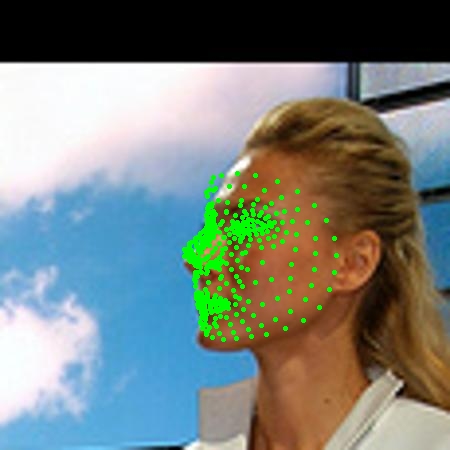

In [41]:
idx = 1
image_file = new_df['image'].iloc[idx] + '.jpg'
image = cv2.imread(image_file)
for x, y in zip(new_df.iloc[idx, 1:-3:2], new_df.iloc[idx, 2:-3:2]):
  cv2.circle(image, (x, y), radius=1, color=(0, 255, 0), thickness=2)

cv2_imshow(image)

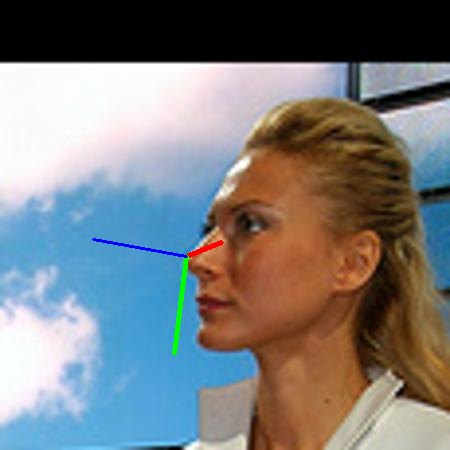

In [42]:
image = cv2.imread(image_file)
tdx, tdy = new_df[['l2', 'l3']].iloc[idx]
annotated_image = draw_axis(image, new_df['pitch'].iloc[idx], new_df['yaw'].iloc[idx], new_df['roll'].iloc[idx], tdx, tdy, size = 100)
cv2_imshow(annotated_image)

Save a copy of this dataframe

In [43]:
new_df.to_csv('/content/data.csv', index=None)

# 5. Explore the Features & Labels 

In [44]:
load_df = pd.read_csv('/content/data.csv')

In [45]:
load_df.head()

,image,l0,l1,l2,l3,l4,l5,l6,l7,l8,...,l949,l950,l951,l952,l953,l954,l955,pitch,yaw,roll
0,/content/AFLW2000/image00002,212,319,215,293,216,295,211,256,216,...,210,278,198,265,208,277,220,-0.399231,0.018227,0.085676
1,/content/AFLW2000/image00004,201,293,186,256,200,267,195,238,186,...,225,248,219,244,224,248,230,0.470065,1.189533,0.300959
2,/content/AFLW2000/image00006,141,357,140,349,140,352,137,336,140,...,320,163,317,159,320,163,323,-0.184650,0.881137,-0.236852
3,/content/AFLW2000/image00008,229,310,211,294,220,296,200,266,208,...,209,250,205,244,215,254,219,-0.175379,0.299208,-0.373374
4,/content/AFLW2000/image00013,231,306,223,273,225,281,211,244,221,...,206,253,200,246,209,256,215,-0.026812,0.011965,-0.220662


observe the distribution of the features and labels

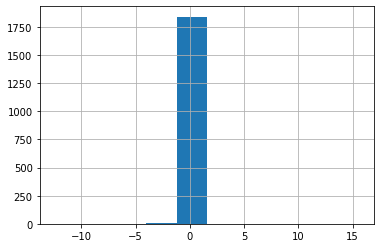

In [46]:
load_df['pitch'].hist()

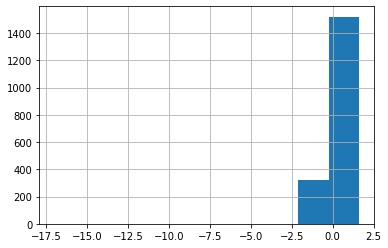

In [47]:
load_df['roll'].hist()

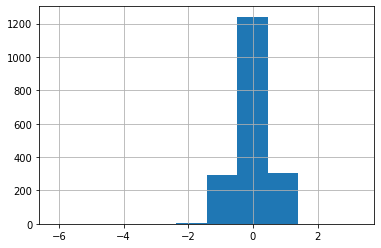

In [48]:
load_df['yaw'].hist()

# 6. Date Splitting

we will split the date into (train, validations, test) with the ratio (70, 20, 10) as the data is not so big

In [52]:
X = load_df.iloc[:, 1:-3]

In [53]:
X.head()

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l946,l947,l948,l949,l950,l951,l952,l953,l954,l955
0,212,319,215,293,216,295,211,256,216,285,...,277,209,289,210,278,198,265,208,277,220
1,201,293,186,256,200,267,195,238,186,249,...,248,225,253,225,248,219,244,224,248,230
2,141,357,140,349,140,352,137,336,140,345,...,163,320,166,320,163,317,159,320,163,323
3,229,310,211,294,220,296,200,266,208,287,...,252,212,260,209,250,205,244,215,254,219
4,231,306,223,273,225,281,211,244,221,264,...,254,208,263,206,253,200,246,209,256,215


In [54]:
y = load_df[['pitch', 'yaw', 'roll']] 

In [55]:
y.head()

,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.026812,0.011965,-0.220662


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [57]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [58]:
X_train.shape

(1292, 956)

In [59]:
X_val.shape

(371, 956)

In [60]:
X_test.shape

(183, 956)

In [61]:
X_train.head()

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l946,l947,l948,l949,l950,l951,l952,l953,l954,l955
58,225,300,227,282,227,286,219,247,227,272,...,278,210,288,210,278,203,269,210,278,218
1469,230,301,238,275,234,283,230,245,239,266,...,267,216,276,217,268,208,258,215,267,224
1592,227,311,211,282,221,291,201,255,208,273,...,263,207,272,204,261,200,255,210,266,214
363,224,295,210,279,219,282,208,256,208,272,...,253,225,260,224,252,219,247,226,254,231
1610,212,298,218,277,218,283,219,248,220,269,...,282,231,290,232,283,224,274,229,281,237


# 7. Feature Scaling

we will use standardization scaling as the data has a normal distribution

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
scaled_x_train = scaler.transform(X_train)
scaled_x_val = scaler.transform(X_val)
scaled_x_test = scaler.transform(X_test)

save the scaler

In [ ]:
import joblib
joblib.dump(scaler, '/content/scaler.save') 

# 8. Train Different Models

We will try different models for this problem and pick the best one

In [201]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
def evaluate_model(model):
  print("model score: ", model.score(scaled_x_val, y_val))
  y_train_predict=model.predict(scaled_x_train)
  y_val_predict=model.predict(scaled_x_val)
  print("model training error: ", np.sqrt(mean_squared_error(y_train,y_train_predict)))
  print("model validation error: ", np.sqrt(mean_squared_error(y_val,y_val_predict)))

## 8.1 linear regression

In [ ]:
pitch_reg = LinearRegression().fit(scaled_x_train, y_train['pitch'])
pitch_reg.score(scaled_x_val, y_val['pitch'])

-11.212376980941857

In [ ]:
yaw_reg = LinearRegression().fit(scaled_x_train, y_train['yaw'])
pitch_reg.score(scaled_x_val, y_val['yaw'])

-2.881119911704103

In [ ]:
pitch_reg = LinearRegression().fit(scaled_x_train, y_train['roll'])
pitch_reg.score(scaled_x_val, y_val['roll'])

-4.454958203119677

try multi regressor

In [ ]:
multi_reg = MultiOutputRegressor(LinearRegression()).fit(scaled_x_train, y_train)
evaluate_model(multi_reg)

model score:  -5.035941926253961
model training error:  0.19797801191413336
model validation error:  0.7633382021042783


## 8.2 lasso

In [ ]:
multi_poly_reg = MultiOutputRegressor(Lasso(alpha=0.005)).fit(scaled_x_train, y_train)
evaluate_model(multi_poly_reg)

model score:  0.6625399509304392
model training error:  0.5100363471704171
model validation error:  0.19535302428829548


In [ ]:
multi_poly_reg = MultiOutputRegressor(Lasso(alpha=0.01)).fit(scaled_x_train, y_train)
evaluate_model(multi_poly_reg)

model score:  0.5295063945435997
model training error:  0.5295340081193931
model validation error:  0.22701941545228513


## 8.3 Ridge

In [ ]:
multi_ridge_reg = MultiOutputRegressor(Ridge(alpha=0.5)).fit(scaled_x_train, y_train)
evaluate_model(multi_ridge_reg)

model score:  0.6939192661159111
model training error:  0.4691579166048834
model validation error:  0.18641614466642645
model score:  0.6939192661159111


In [ ]:
multi_ridge_reg = MultiOutputRegressor(Ridge(alpha=0.1)).fit(scaled_x_train, y_train)
evaluate_model(multi_ridge_reg)

model score:  0.6343972771378733
model training error:  0.4461779355752118
model validation error:  0.20132311242990245
model score:  0.6343972771378733


## 8.4 SVR

The best validation error after tuning the SVR

In [ ]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', degree=2, epsilon=.1, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.8260290920028454
model training error:  0.4859329492719248
model validation error:  0.13582670350031975


### 8.4.1 Tuning the SVR parameters

In [ ]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1, coef0=1)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.807137284935585
model training error:  0.5099618018335746
model validation error:  0.1455268765545718


In [ ]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.1, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.7982724722703121
model training error:  0.5068728554279238
model validation error:  0.14899346278189185


In [ ]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', C=100, gamma='auto', degree=2, epsilon=.5, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.6799968221837532
model training error:  0.5094036984705202
model validation error:  0.19560827255001115


In [ ]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', C=10, degree=2, epsilon=.5, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.5304179226264155
model training error:  0.43585898603927736
model validation error:  0.23457738346755616


In [ ]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', C=2, degree=2, epsilon=.5, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.6263850860606573
model training error:  0.4786211266859973
model validation error:  0.20829829485638796


In [ ]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', gamma='auto', degree=2, epsilon=.1, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.5628222486721038
model training error:  0.5480324437907244
model validation error:  0.2476497849128329


In [ ]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', degree=3, epsilon=.1, coef0=0)).fit(scaled_x_train, y_train)
evaluate_model(multi_svr)

model score:  0.8388122744145571
model training error:  0.38632712127496
model validation error:  0.13164317097219944


## 8.5 Decision Tree

The best validation error after tuning the Decision Tree

In [ ]:
multi_dt = MultiOutputRegressor(DecisionTreeRegressor(max_depth=5)).fit(scaled_x_train, y_train)
evaluate_model(multi_dt)

model score:  0.7336551146047022
model training error:  0.13394530642935146
model validation error:  0.16995136895795748


### 8.5.1 Tuning the Decision Tree

In [ ]:
multi_dt = MultiOutputRegressor(DecisionTreeRegressor(max_depth=2)).fit(scaled_x_train, y_train)
evaluate_model(multi_dt)

model score:  0.39497979737337435
model training error:  0.26523363947055023
model validation error:  0.26497516706600754


In [ ]:
multi_dt = MultiOutputRegressor(DecisionTreeRegressor(max_depth=4)).fit(scaled_x_train, y_train)
evaluate_model(multi_dt)

model score:  0.7359114635348883
model training error:  0.15918428361423745
model validation error:  0.17398952212071175


In [ ]:
multi_dt = MultiOutputRegressor(DecisionTreeRegressor(max_depth=10)).fit(scaled_x_train, y_train)
evaluate_model(multi_dt)

model score:  0.7208461405038094
model training error:  0.049209715145453754
model validation error:  0.17182691362362956


## 8.6 Random Forest

The best validation error after tuning the Random Forest

In [ ]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=9)).fit(scaled_x_train, y_train)
evaluate_model(multi_rf)

model score:  0.8236111906899867
model training error:  0.25735743205068706
model validation error:  0.13640924147741101


### 8.6.1 Tuning the Random Forest

In [ ]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=5)).fit(scaled_x_train, y_train)
evaluate_model(multi_rf)

model score:  0.7200503942255073
model training error:  0.21659837676318974
model validation error:  0.173577722651002


In [ ]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=6)).fit(scaled_x_train, y_train)
evaluate_model(multi_rf)

model score:  0.6184095460615335
model training error:  0.29389828013918684
model validation error:  0.2048429854182834


In [ ]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=7)).fit(scaled_x_train, y_train)
evaluate_model(multi_rf)

model score:  0.7228325561364732
model training error:  0.24490984293222431
model validation error:  0.16801849235123834


In [ ]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=8)).fit(scaled_x_train, y_train)
evaluate_model(multi_rf)

model score:  0.8123663421776524
model training error:  0.2899342647612019
model validation error:  0.14023080572455576


## 8.7 Training Conclusion

|Metric          |Lasso|Ridge|SVR|Decision Tree|Random Forest
|---------------|:-----------------|:-----------------|:-----------------|:-----------------|:-----------------|
|Accuracy       |0.66|0.69|0.826|0.73|0.824|
|Training RMSE  |0.51|0.45|0.49|0.13|0.26|
|Validation RMSE|0.2|0.19|0.14|0.17|0.14|


Both SVR & Random Forest have great performance, so I will try both in the testing and for predicting the video and see which has better outcome

# 9. Test Model

In [ ]:
final_model = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=9)).fit(scaled_x_train, y_train)
y_test_predict=final_model.predict(scaled_x_test)
print("model test error: ", np.sqrt(mean_squared_error(y_test,y_test_predict)))

model test error:  0.1837286072632466


In [ ]:
final_model_2 = MultiOutputRegressor(SVR(kernel='poly', degree=2, epsilon=.1, coef0=0)).fit(scaled_x_train, y_train)
y_test_predict=final_model_2.predict(scaled_x_test)
print("model test error: ", np.sqrt(mean_squared_error(y_test,y_test_predict)))

model test error:  0.17470492019016445


# 10. Save Model

In [64]:
import joblib

In [ ]:
joblib.dump(final_model, '/content/RF_model2.pkl')

['/content/RF_model2.pkl']

In [ ]:
joblib.dump(final_model_2, '/content/SVR_model.pkl')

['/content/SVR_model.pkl']

# 11. Predict

In [72]:
model = joblib.load('/content/SVR_model.pkl')
model2 = joblib.load('/content/RF_model2.pkl')
scaler = joblib.load('/content/scaler.save')

In [66]:
y_test.head()

,pitch,yaw,roll
350,0.107772,0.277356,-0.272857
383,-0.475047,-0.124656,0.049033
974,-0.278754,0.222314,-0.121052
1636,-0.017245,0.290250,0.298698
1177,-0.186096,-0.102314,-0.536701


In [75]:
idx = 1636
predict_trial_landmarks = load_df.iloc[idx, 1:-3]
scaled_predict_trial_landmarks = scaler.transform(predict_trial_landmarks.values.reshape(1, -1))
scaled_predict_trial_landmarks.shape

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


(1, 956)

In [76]:
predicted_pose = model.predict(scaled_predict_trial_landmarks)
predicted_pose

array([[0.0092108 , 0.33327423, 0.31311161]])

In [77]:
predicted_pose2 = model2.predict(scaled_predict_trial_landmarks)
predicted_pose2

array([[-0.10666295,  0.32289083,  0.3187889 ]])

In [78]:
image_file = new_df['image'].iloc[idx] + '.jpg'
image = cv2.imread(image_file)
tdx, tdy = load_df[['l2', 'l3']].iloc[idx]

The correct angles

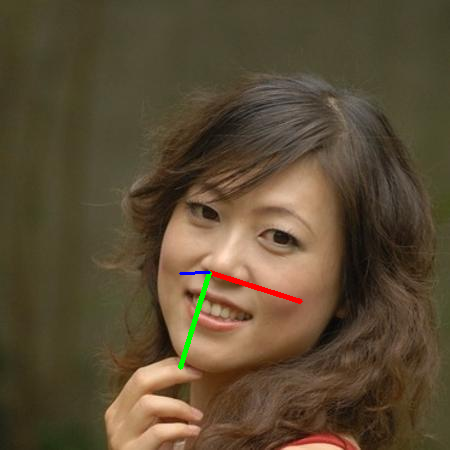

In [79]:
annotated_image = draw_axis(image, load_df['pitch'].iloc[idx], load_df['yaw'].iloc[idx], new_df['roll'].iloc[idx], tdx, tdy, size = 100)
cv2_imshow(annotated_image)

Predicting with SVR

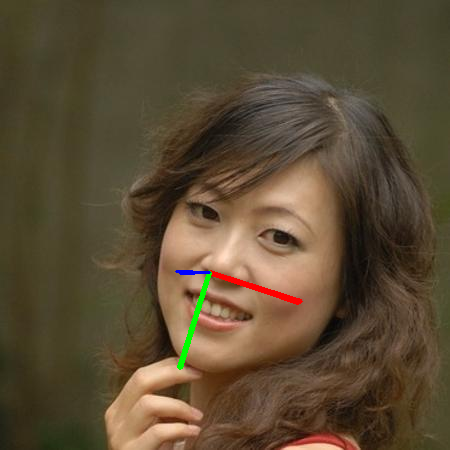

In [80]:
tdx, tdy = load_df[['l2', 'l3']].iloc[idx]
annotated_image = draw_axis(image, predicted_pose[0][0], predicted_pose[0][1], predicted_pose[0][2], tdx, tdy, size = 100)
cv2_imshow(annotated_image)

Predicting wiht Random Forest

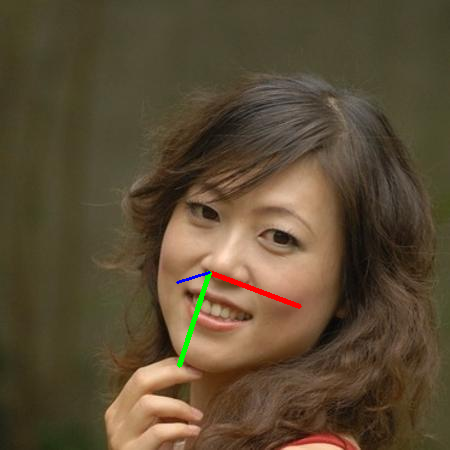

In [81]:
image_file = new_df['image'].iloc[idx] + '.jpg'
image = cv2.imread(image_file)
tdx, tdy = load_df[['l2', 'l3']].iloc[idx]
annotated_image = draw_axis(image, predicted_pose2[0][0], predicted_pose2[0][1], predicted_pose2[0][2], tdx, tdy, size = 100)
cv2_imshow(annotated_image)

# 12. Predict For A Video

In [ ]:
!cp /content/drive/MyDrive/Head_Pose_Estimation/vid.mp4 /content

In [ ]:
!pip install moviepy

!pip3 install imageio==2.4.1

!pip install --upgrade imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from moviepy.editor import VideoFileClip

In [ ]:
model = joblib.load('/content/RF_model2.pkl')

In [ ]:
def get_2d_features_predict(image):
  mp_face_mesh = mp.solutions.face_mesh
  with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.3) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
      face_landmarks = list(results.multi_face_landmarks[0].landmark)
      face_landmarks_2d = list(map(lambda landmark: [int(landmark.x * image.shape[0]), int(landmark.y * image.shape[1])], face_landmarks))
      return np.array(face_landmarks_2d, dtype=int).flatten()
    
    return None

In [ ]:
def pipeline(frame):
    frame = cv2.resize(frame, (450, 450), interpolation = cv2.INTER_AREA)
    landmarks = get_2d_features_predict(frame)
    if landmarks is not None:
        tdx, tdy = landmarks[2], landmarks[3]
        landmarks = scaler.transform(X=landmarks.reshape(1, -1))
        predicted_pose = model.predict(landmarks.reshape(1, -1))
        annotated_image = draw_axis(frame, predicted_pose[0][0], predicted_pose[0][1], predicted_pose[0][2], tdx, tdy, size = 100)
        return annotated_image
    
    return frame

In [ ]:
white_output = '/content/vid_out.mp4'
clip1 = VideoFileClip('/content/vid.mp4')
white_clip = clip1.fl_image(pipeline) 
%time white_clip.write_videofile(white_output, audio=False)   

After trying both models, Random Forest gives better results for the video prediction

# 13. Refinements

Now we will try to normalize the features, change its center to be the nose and divide by the largest distance between the chin & the forehead.

This will help the features to be invariant with the translation of the face along the picture so that the model would be more robust.

## 13.1 Normalize the landmarks

Knowing that nose landmarks (l2, l3)

Forhead landmarks (l10, l11)

Chin landmarks (l152, ll53)

In [329]:
load_df.iloc[:, 150:158].head()

,l149,l150,l151,l152,l153,l154,l155,l156
0,315,197,284,183,315,185,319,185
1,297,196,263,199,300,198,301,200
2,360,131,349,121,363,122,367,122
3,314,204,294,210,315,213,318,212
4,314,207,280,206,318,210,319,208


In [330]:
X = load_df.iloc[:, 1:-3]

In [331]:
nose_x, nose_y = X['l2'].copy(), X['l3'].copy() 

In [332]:
nose_x

0       215
1       186
2       140
3       211
4       223
       ... 
1841    241
1842    255
1843    225
1844    268
1845    231
Name: l2, Length: 1846, dtype: int64

In [333]:
for x_col, y_col in zip(X.columns[::2], X.columns[1::2]):
  X[x_col] = X[x_col] - nose_x
  X[y_col] = X[y_col] - nose_y

In [334]:
X.head()

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l946,l947,l948,l949,l950,l951,l952,l953,l954,l955
0,-3,26,0,0,1,2,-4,-37,1,-8,...,62,-84,74,-83,63,-95,50,-85,62,-73
1,15,37,0,0,14,11,9,-18,0,-7,...,62,-31,67,-31,62,-37,58,-32,62,-26
2,1,8,0,0,0,3,-3,-13,0,-4,...,23,-29,26,-29,23,-32,19,-29,23,-26
3,18,16,0,0,9,2,-11,-28,-3,-7,...,41,-82,49,-85,39,-89,33,-79,43,-75
4,8,33,0,0,2,8,-12,-29,-2,-9,...,31,-65,40,-67,30,-73,23,-64,33,-58


Now for each image get the distance between the chin & forehead and divide all the points by that distance

In [335]:
def get_dist(x1, y1, x2, y2):
  return np.linalg.norm([x1-x2, y1-y2], 2)

In [336]:
X = X.apply(lambda row: row/get_dist(row[10], row[11], row[152], row[153]), axis=1)

In [337]:
X.head()

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l946,l947,l948,l949,l950,l951,l952,l953,l954,l955
0,-0.053191,0.460990,0.0,0.0,0.017730,0.035461,-0.070922,-0.656024,0.017730,-0.141843,...,1.099284,-1.489352,1.312048,-1.471622,1.117014,-1.684387,0.886519,-1.507083,1.099284,-1.294318
1,0.256195,0.631948,0.0,0.0,0.239115,0.187876,0.153717,-0.307434,0.000000,-0.119558,...,1.058940,-0.529470,1.144338,-0.529470,1.058940,-0.631948,0.990621,-0.546550,1.058940,-0.444072
2,0.033520,0.268161,0.0,0.0,0.000000,0.100560,-0.100560,-0.435761,0.000000,-0.134080,...,0.770962,-0.972082,0.871522,-0.972082,0.770962,-1.072642,0.636881,-0.972082,0.770962,-0.871522
3,0.447767,0.398015,0.0,0.0,0.223883,0.049752,-0.273635,-0.696526,-0.074628,-0.174132,...,1.019913,-2.039826,1.218921,-2.114454,0.970161,-2.213958,0.820906,-1.965198,1.069665,-1.865695
4,0.118927,0.490574,0.0,0.0,0.029732,0.118927,-0.178391,-0.431111,-0.029732,-0.133793,...,0.460842,-0.966282,0.594635,-0.996014,0.445976,-1.085209,0.341915,-0.951417,0.490574,-0.862221


save the normalized features

In [338]:
X.to_csv('norm_features.csv', index=None)

## 13.2 Split The Data

In [339]:
X = pd.read_csv('norm_features.csv')

In [340]:
X.head()

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l946,l947,l948,l949,l950,l951,l952,l953,l954,l955
0,-0.053191,0.460990,0.0,0.0,0.017730,0.035461,-0.070922,-0.656024,0.017730,-0.141843,...,1.099284,-1.489352,1.312048,-1.471622,1.117014,-1.684387,0.886519,-1.507083,1.099284,-1.294318
1,0.256195,0.631948,0.0,0.0,0.239115,0.187876,0.153717,-0.307434,0.000000,-0.119558,...,1.058940,-0.529470,1.144338,-0.529470,1.058940,-0.631948,0.990621,-0.546550,1.058940,-0.444072
2,0.033520,0.268161,0.0,0.0,0.000000,0.100560,-0.100560,-0.435761,0.000000,-0.134080,...,0.770962,-0.972082,0.871522,-0.972082,0.770962,-1.072642,0.636881,-0.972082,0.770962,-0.871522
3,0.447767,0.398015,0.0,0.0,0.223883,0.049752,-0.273635,-0.696526,-0.074628,-0.174132,...,1.019913,-2.039826,1.218921,-2.114454,0.970161,-2.213958,0.820906,-1.965198,1.069665,-1.865695
4,0.118927,0.490574,0.0,0.0,0.029732,0.118927,-0.178391,-0.431111,-0.029732,-0.133793,...,0.460842,-0.966282,0.594635,-0.996014,0.445976,-1.085209,0.341915,-0.951417,0.490574,-0.862221


In [341]:
y = load_df[['pitch', 'yaw', 'roll']] 
y.head()

,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.026812,0.011965,-0.220662


In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [343]:
X_train.head()

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l946,l947,l948,l949,l950,l951,l952,l953,l954,l955
58,-0.032853,0.295679,0.0,0.0,0.000000,0.065706,-0.131413,-0.574930,0.000000,-0.164266,...,0.837756,-1.182714,1.002022,-1.182714,0.837756,-1.297700,0.689917,-1.182714,0.837756,-1.051301
1469,-0.100440,0.326431,0.0,0.0,-0.050220,0.100440,-0.100440,-0.376651,0.012555,-0.112995,...,0.364096,-0.740748,0.477092,-0.728193,0.376651,-0.841188,0.251101,-0.753303,0.364096,-0.640308
1592,0.213031,0.386118,0.0,0.0,0.133144,0.119830,-0.133144,-0.359489,-0.039943,-0.119830,...,0.692349,-0.998581,0.812179,-1.038524,0.665721,-1.091782,0.585834,-0.958638,0.732293,-0.905380
363,0.363913,0.415900,0.0,0.0,0.233944,0.077981,-0.051988,-0.597857,-0.051988,-0.181956,...,1.117732,-1.403663,1.299688,-1.429657,1.091738,-1.559626,0.961769,-1.377669,1.143726,-1.247701
1610,-0.120775,0.422714,0.0,0.0,0.000000,0.120775,0.020129,-0.583748,0.040258,-0.161034,...,1.288271,-0.925945,1.449305,-0.905816,1.308401,-1.066850,1.127238,-0.966204,1.268142,-0.805170


## 13.3 Training SVR & Random Forest

In [195]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

In [207]:
def evaluate_model(model):
  print("model score: ", model.score(X_val, y_val))
  y_train_predict=model.predict(X_train)
  y_val_predict=model.predict(X_val)
  print("model training error: ", np.sqrt(mean_squared_error(y_train,y_train_predict)))
  print("model validation error: ", np.sqrt(mean_squared_error(y_val,y_val_predict)))

SVR

In [344]:
multi_svr = MultiOutputRegressor(SVR(kernel='rbf', C = 100, epsilon=.1, coef0=0)).fit(X_train, y_train)
evaluate_model(multi_svr)

model score:  0.8427790920723169
model training error:  0.34448791500358905
model validation error:  0.129763657924707


In [345]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly', degree=2, epsilon=.1, coef0=0)).fit(X_train, y_train)
evaluate_model(multi_svr)

model score:  0.7994173030960366
model training error:  0.5129330697150788
model validation error:  0.1512520723672026


In [346]:
multi_svr = MultiOutputRegressor(SVR(kernel='poly',C=100, degree=2, epsilon=.1, coef0=0)).fit(X_train, y_train)
evaluate_model(multi_svr)

model score:  0.8033159054510826
model training error:  0.47964181530485134
model validation error:  0.146873893138501


Random Forest

In [347]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=8, n_estimators=6)).fit(X_train, y_train)
evaluate_model(multi_rf)

model score:  0.6325371498656382
model training error:  0.2963329462326468
model validation error:  0.20546228957132462


In [348]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=10, n_estimators=9)).fit(X_train, y_train)
evaluate_model(multi_rf)

model score:  0.430119785596033
model training error:  0.3574734408570057
model validation error:  0.2502621815097715


In [ ]:
multi_rf = MultiOutputRegressor(RandomForestRegressor(max_depth=8, n_estimators=6)).fit(X_train, y_train)
evaluate_model(multi_rf)

### 13.3.1 Training Conclusion

|Metric          |SVR|Random Forest
|---------------|:-----------------|:-----------------|
|Accuracy       |0.84|0.63|
|Training RMSE  |0.34|0.29|
|Validation RMSE|0.13|0.21|


It's clear that SVR has better performance

## 13.4 Test & Save Model

In [349]:
final_model = MultiOutputRegressor(SVR(kernel='rbf', C = 100, epsilon=.1, coef0=0)).fit(X_train, y_train)
y_test_predict=final_model.predict(X_test)
print("model test error: ", np.sqrt(mean_squared_error(y_test,y_test_predict)))

model test error:  0.22618633838208482


In [350]:
import joblib

In [351]:
joblib.dump(final_model, '/content/svr_model_norm.pkl')

['/content/svr_model_norm.pkl']

## 13.6 Predict

In [352]:
model = joblib.load('/content/svr_model_norm.pkl')

In [353]:
idx = 1636
predict_trial_landmarks = load_df.iloc[idx, 1:-3]
tdx, tdy = predict_trial_landmarks[2], predict_trial_landmarks[3]
# subtract from the nose
predict_trial_landmarks[::2] = predict_trial_landmarks[::2] - tdx
predict_trial_landmarks[1::2] = predict_trial_landmarks[1::2] - tdy

# divide by the distance
distance = get_dist(predict_trial_landmarks[10], predict_trial_landmarks[11], predict_trial_landmarks[152], predict_trial_landmarks[153])
predict_trial_landmarks = predict_trial_landmarks / distance


In [321]:
predict_trial_landmarks.tail()

l951   -0.860729
l952    1.343578
l953   -0.776756
l954    1.469538
l955   -0.566822
Name: 1636, dtype: object

In [357]:
predicted_pose = model.predict(X=np.array(predict_trial_landmarks).reshape(1, -1))
predicted_pose

  warnings.warn(

  warnings.warn(

  warnings.warn(



array([[-0.04487822,  0.34066128,  0.30987181]])

In [358]:
image_file = new_df['image'].iloc[idx] + '.jpg'
image = cv2.imread(image_file)
tdx, tdy = load_df[['l2', 'l3']].iloc[idx]

The correct angles

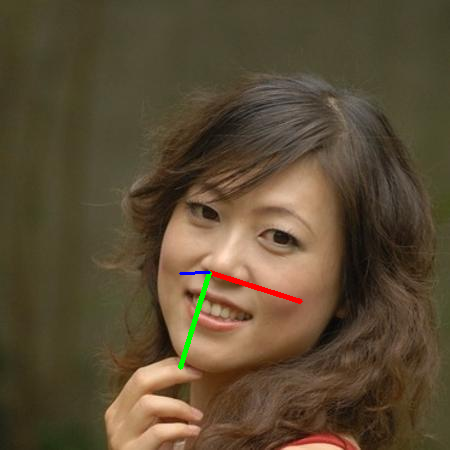

In [359]:
annotated_image = draw_axis(image, load_df['pitch'].iloc[idx], load_df['yaw'].iloc[idx], new_df['roll'].iloc[idx], tdx, tdy, size = 100)
cv2_imshow(annotated_image)

Predicting with SVR

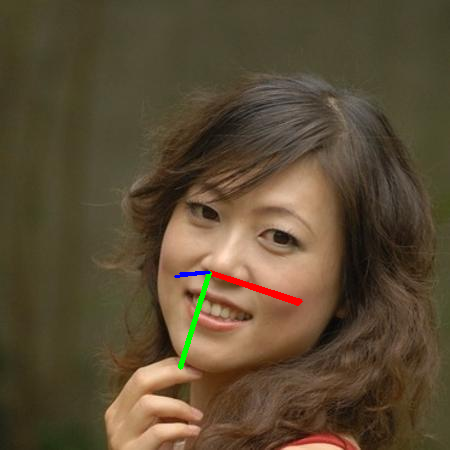

In [360]:
tdx, tdy = load_df[['l2', 'l3']].iloc[idx]
annotated_image = draw_axis(image, predicted_pose[0][0], predicted_pose[0][1], predicted_pose[0][2], tdx, tdy, size = 100)
cv2_imshow(annotated_image)

## 13.5 Predict For Video

In [222]:
!cp /content/drive/MyDrive/Head_Pose_Estimation/vid_1.mp4 /content

In [223]:
!cp /content/drive/MyDrive/Head_Pose_Estimation/vid_2.mp4 /content

In [ ]:
!pip install moviepy

!pip3 install imageio==2.4.1

!pip install --upgrade imageio-ffmpeg

In [225]:
from moviepy.editor import VideoFileClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3678208/45929032 bytes (8.0%)7438336/45929032 bytes (16.2%)11100160/45929032 bytes (24.2%)15089664/45929032 bytes (32.9%)19161088/45929032 bytes (41.7%)23265280/45929032 bytes (50.7%)27271168/45929032 bytes (59.4%)31293440/45929032 bytes (68.1%)35168256/45929032 bytes (76.6%)38404096/45929032 bytes (83.6%)42393600/45929032 bytes (92.3%)45929032/45929032 bytes (100.0%)

In [363]:
model = joblib.load('/content/svr_model_norm.pkl')

In [362]:
def get_2d_features_predict(image):
  mp_face_mesh = mp.solutions.face_mesh
  with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.3) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
      face_landmarks = list(results.multi_face_landmarks[0].landmark)
      face_landmarks_2d = list(map(lambda landmark: [int(landmark.x * image.shape[0]), int(landmark.y * image.shape[1])], face_landmarks))
      return np.array(face_landmarks_2d, dtype=int).flatten()
    
    return None

In [361]:
def get_dist(x1, y1, x2, y2):
  return np.linalg.norm([x1-x2, y1-y2])

In [367]:
def pipeline(frame):
    # frame = cv2.resize(frame, (450, 450), interpolation = cv2.INTER_AREA)
    landmarks = get_2d_features_predict(frame)
    if landmarks is not None:
        tdx, tdy = landmarks[2].copy(), landmarks[3].copy()
        # subtract from the nose
        landmarks[::2] = landmarks[::2] - tdx
        landmarks[1::2] = landmarks[1::2] - tdy

        # divide by the distance
        distance = get_dist(landmarks[10], landmarks[11], landmarks[152], landmarks[153])
        landmarks = landmarks / distance
        
        predicted_pose = model.predict(landmarks.reshape(1, -1))
        annotated_image = draw_axis(frame, predicted_pose[0][0], predicted_pose[0][1], predicted_pose[0][2], tdx, tdy, size = 100)
        return annotated_image
    
    return frame

In [369]:
white_output = '/content/vid_out.mp4'
clip1 = VideoFileClip('/content/vid_2.mp4')
white_clip = clip1.fl_image(pipeline) 
%time white_clip.write_videofile(white_output, audio=False)   

  warnings.warn(

  warnings.warn(

  warnings.warn(



[MoviePy] >>>> Building video /content/vid_out.mp4
[MoviePy] Writing video /content/vid_out.mp4


Streaming output truncated to the last 5000 lines.
  warnings.warn(

  3%|▎         | 18/573 [00:01<01:02,  8.82it/s]WARNING:py.warnings:/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(

  warnings.warn(

  warnings.warn(

  3%|▎         | 19/573 [00:01<01:03,  8.69it/s]WARNING:py.warnings:/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(

  warnings.warn(

  warnings.warn(

  3%|▎         | 20/573 [00:02<01:03,  8.67it/s]WARNING:py.warnings:/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(

  warnings.warn(

  warnings.warn(

  4%|▎         | 21/573 [00:02<01:05,  8.43it/s]WARNING:py.warnings:/usr/local/lib/python3.8/dist-packages/sklearn/base.p

[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/vid_out.mp4 

CPU times: user 39.2 s, sys: 2.2 s, total: 41.4 s
Wall time: 1min 6s
